# Import libraries

In [1]:
import matplotlib.pyplot  as plt
import numpy as np 

import tensorflow as tf
from keras import layers, models, Sequential
from keras.api.layers import  Conv2D, Flatten
from keras.api.utils import image_dataset_from_directory
from sklearn.model_selection import train_test_split

2025-02-19 17:02:13.685549: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740006133.769332  278440 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740006133.791292  278440 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-19 17:02:14.012710: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Data loading

In [2]:
# Local data path
data_dir = "/home/labrubius/projet/ticket3.11/data"      

In [3]:
train_data = image_dataset_from_directory(data_dir,
                                          validation_split=0.3,
                                          subset="training",
                                          seed=123,
                                          batch_size=32,
                                          image_size=(224,224),
                                          color_mode="grayscale")

Found 149 files belonging to 47 classes.
Using 105 files for training.


I0000 00:00:1740006142.274801  278440 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9711 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:01:00.0, compute capability: 8.6


In [4]:
# data set from which the validation and test data will be subdivided.
val_test_data = image_dataset_from_directory(data_dir,
                                   validation_split=0.30,
                                   subset="validation",
                                   seed=123,
                                   batch_size=32,
                                   image_size=(224,224),
                                   color_mode="grayscale")

Found 149 files belonging to 47 classes.
Using 44 files for validation.


In [5]:
class_names = train_data.class_names
print(class_names)

['alsea', 'autobuses expreso futura', 'bodega aurrera', 'boticas doña josefa', 'candegas', 'chedrahui', 'cinepolis', 'comercializadora alpacel', 'conasuper', 'cooperativa de consumo voluntad compartida de huixtepec', 'coppel', 'correos de méxico', 'decathlon', 'el sabroso', 'equipo gastronómico del bajío', 'estrella roja', 'farma pronto', 'farmacia del ahorro', 'farmacia oaxaqueña de más ahorro', 'ferretería damajo', 'frutas y verduras toño', 'gasolina', 'grupo comercial dsw', 'home depot', 'la gloria', 'libreía san francisco', 'little caesars', 'liverpool', 'miniso', 'nueva imagen', 'nuriko sushi express', 'oxxo', 'pacalli', 'parisina', 'recibo de compra', 'retiro', 'sally beauty supply', 'santa clara', 'steren', 'super farmacia', 'superq', 'tartamiel', 'tres mulatas', 'va', 'vivco alimentos', 'waldo', 'walmart']


In [47]:
type(train_data)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [6]:
# Split val_test_data into validation (15%) and test (15%)
val_images = np.concatenate([x for x, _ in val_test_data])
val_labels = np.concatenate([y for _, y in val_test_data])

val_images, test_images, val_labels, test_labels = train_test_split(
    val_images, val_labels, test_size=0.5, random_state=123
)

2025-02-19 17:02:32.932504: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2025-02-19 17:02:33.138501: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [7]:
# Create TensorFlow datasets for validation and testing
val_ds = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((test_images, test_labels)).batch(32)


In [50]:
type(test_ds)

tensorflow.python.data.ops.batch_op._BatchDataset

# Data normalization

In [51]:
# def normalize(image,label):
#     image = tf.cast(image, tf.float32) / 255
#     return image, label

In [52]:
# train_data = train_data.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
# test_ds = test_ds.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)
# val_ds = val_ds.map(normalize, num_parallel_calls=tf.data.AUTOTUNE)

In [8]:
print(f"Train: {len(train_data)}")
print(f"Validation: {len(val_ds)}")
print(f"Test: {len(test_ds)}")

Train: 4
Validation: 1
Test: 1


In [54]:
type(train_data)

tensorflow.python.data.ops.prefetch_op._PrefetchDataset

In [9]:
for images, labels in train_data.take(1):
    print(images.shape)

(32, 224, 224, 1)


# Data visualization

2025-02-19 17:02:48.277124: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


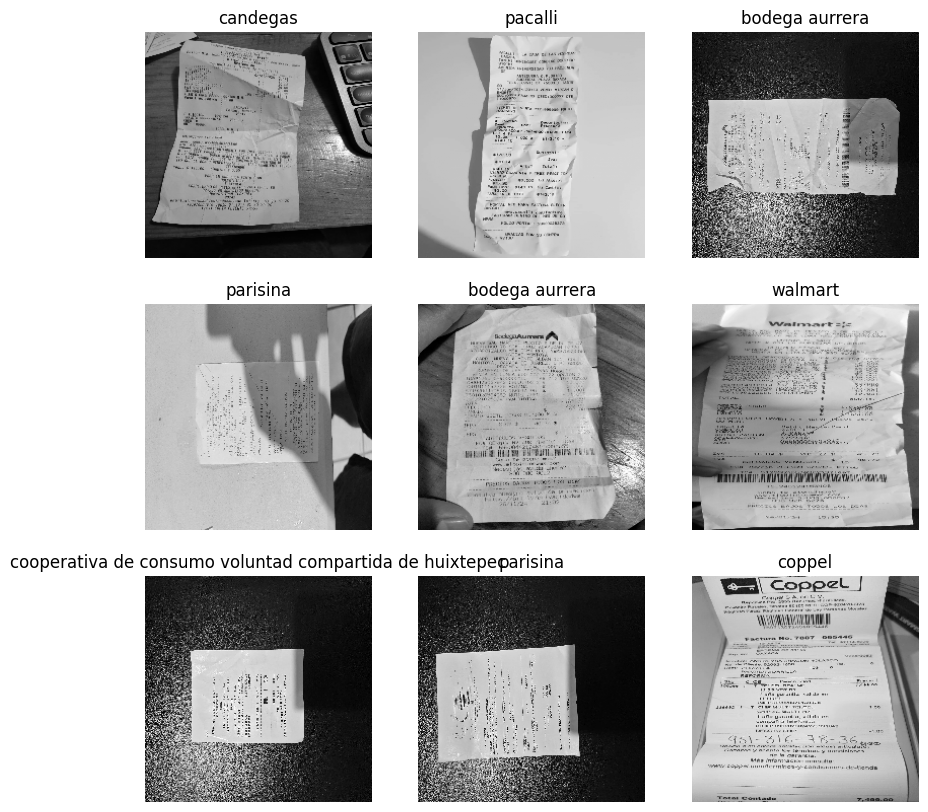

In [10]:
plt.figure(figsize=(10,10))
for images, labels  in train_data.take(1):
    images = images.numpy()
    labels = labels.numpy()
    
    for i in range(min(9, len(images))):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].squeeze(), cmap="gray")
        plt.title(class_names[int(labels[i])])
        plt.axis("off")      

plt.show()
   

# Creation of the Neural Network

In [11]:
data_augmentation = Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1) 
])

In [12]:
# Creating the convolutional base 
model = models.Sequential([
    layers.Rescaling(1./ 255, input_shape= (224,224,1)),
    data_augmentation,
    
    
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(224, 224, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation="relu"),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.3), 
    layers.Dense(len(class_names), activation="softmax") 
])

/home/labrubius/.pyenv/versions/ticket_classification/lib/python3.11/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/home/labrubius/.pyenv/versions/ticket_classification/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [13]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 1)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 47)             │         6,063 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,174,447 (42.63 MB)

 Trainable params: 11,174,447 (42.63 MB)

 Non-trainable params: 0 (0.00 B)

# Network compilation

In [14]:
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# Training the network

In [15]:
history = model.fit(train_data,
                    validation_data = val_ds,
                    epochs=10)

Epoch 1/10


I0000 00:00:1740006577.025495  280200 cuda_dnn.cc:529] Loaded cuDNN version 90300


4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 267ms/step - accuracy: 0.1529 - loss: 3.6258 - val_accuracy: 0.1364 - val_loss: 3.7730
Epoch 2/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - accuracy: 0.2848 - loss: 3.4970 - val_accuracy: 0.1364 - val_loss: 3.8214
Epoch 3/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step - accuracy: 0.2643 - loss: 3.4229 - val_accuracy: 0.1364 - val_loss: 3.7431
Epoch 4/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.3049 - loss: 3.1539 - val_accuracy: 0.1364 - val_loss: 3.6247
Epoch 5/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.2560 - loss: 3.2111 - val_accuracy: 0.1364 - val_loss: 3.6229
Epoch 6/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.2476 - loss: 3.1661 - val_accuracy: 0.1364 - val_loss: 4.0572
Epoch 7/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.3007 - loss: 3.1125 - val_accuracy: 0.1364 - val_loss: 3.7015
Epoch 8/10
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.2626 - loss: 3.0635 - val_accuracy: 0.1364 - val_loss: 3.7887
Epoch 9/10

# Results analysis 

In [18]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test accuracy: {test_acc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.1364 - loss: 4.0751
Test accuracy: 0.1364


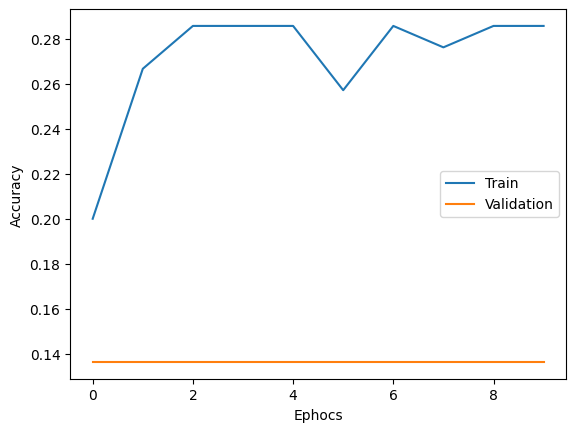

In [19]:
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Validation")
plt.xlabel("Ephocs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Callbacks

# Saving model